# Genetic Algorithm for Feature Selection - Demo Notebook

This notebook demonstrates how to use the **GeneticAlgorithm** class for feature selection on the diabetes dataset.

## Overview
- **Representation:** Continuous feature weights in [0, 1]
- **Selection:** Features with weight ≥ 0.5 are considered "selected"
- **Fitness:** Cross-validation accuracy - λ × (feature_penalty)
- **Elitism:** Top individuals preserved across generations

---

## 1. Import Required Libraries

## 0. Preprocessing: Remove Diagnosis Column

First, we need to remove the 'Diagnosis' feature from the dataset as it's the target variable and shouldn't be used as a feature for prediction.

In [10]:
import pandas as pd
import os

# Path to the CSV file
csv_path = '../data/processed/cleaned_diabetes_data.csv'

# Load the CSV
df = pd.read_csv(csv_path)

print(f"Original shape: {df.shape}")
print(f"Original columns: {df.columns.tolist()}")
print(f"\nDiagnosis column present: {'Diagnosis' in df.columns}")

# Remove Diagnosis column if it exists
if 'Diagnosis' in df.columns:
    df = df.drop('Diagnosis', axis=1)
    print(f"\n✅ Removed 'Diagnosis' column")
else:
    print(f"\n⚠️ 'Diagnosis' column not found")
    
print(f"\nNew shape: {df.shape}")
print(f"Features remaining: {df.shape[1] - 1} (last column is target)")

# Save the updated CSV
df.to_csv(csv_path, index=False)
print(f"\n✅ Saved updated CSV file: {csv_path}")

Original shape: (1879, 52)
Original columns: ['PatientID', 'Age', 'Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryDiabetes', 'GestationalDiabetes', 'PolycysticOvarySyndrome', 'PreviousPreDiabetes', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'AntihypertensiveMedications', 'Statins', 'AntidiabeticMedications', 'FrequentUrination', 'ExcessiveThirst', 'UnexplainedWeightLoss', 'FatigueLevels', 'BlurredVision', 'SlowHealingSores', 'TinglingHandsFeet', 'QualityOfLifeScore', 'HeavyMetalsExposure', 'OccupationalExposureChemicals', 'WaterQuality', 'MedicalCheckupsFrequency', 'MedicationAdherence', 'HealthLiteracy', 'Diagnosis', 'DoctorInCharge', 'Total_Symptoms', 'Polyuria_Polydipsia', 'Skin_Issues', 'Neuro_Symptoms', 'High_Risk_Co

In [11]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Add parent directory to path to import src modules
sys.path.insert(0, os.path.abspath('..'))

from src.genetic_algorithm import GeneticAlgorithm
from src import config
from src.utils import load_data, weights_to_mask, get_selected_features

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"Default dataset path: {config.DEFAULT_DATASET_PATH}")

✅ All libraries imported successfully!
Default dataset path: c:\Users\moham\Desktop\projects\AI project\structure 2\ga-feature-select\data\processed\cleaned_diabetes_data.csv


## 2. Load and Explore the Dataset

In [12]:
# Load the processed diabetes dataset
dataset_path = config.DEFAULT_DATASET_PATH
X, y, feature_names = load_data(dataset_path)

print(f"Dataset loaded: {dataset_path}")
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"\nFeature names:")
for i, name in enumerate(feature_names, 1):
    print(f"  {i}. {name}")

print(f"\nTarget distribution:")
unique, counts = np.unique(y, return_counts=True)
for val, count in zip(unique, counts):
    print(f"  Class {val}: {count} ({count/len(y)*100:.1f}%)")

Dataset loaded: c:\Users\moham\Desktop\projects\AI project\structure 2\ga-feature-select\data\processed\cleaned_diabetes_data.csv
Samples: 1879
Features: 50

Feature names:
  1. PatientID
  2. Age
  3. Gender
  4. Ethnicity
  5. SocioeconomicStatus
  6. EducationLevel
  7. BMI
  8. Smoking
  9. AlcoholConsumption
  10. PhysicalActivity
  11. DietQuality
  12. SleepQuality
  13. FamilyHistoryDiabetes
  14. GestationalDiabetes
  15. PolycysticOvarySyndrome
  16. PreviousPreDiabetes
  17. Hypertension
  18. SystolicBP
  19. DiastolicBP
  20. FastingBloodSugar
  21. HbA1c
  22. SerumCreatinine
  23. BUNLevels
  24. CholesterolTotal
  25. CholesterolLDL
  26. CholesterolHDL
  27. CholesterolTriglycerides
  28. AntihypertensiveMedications
  29. Statins
  30. AntidiabeticMedications
  31. FrequentUrination
  32. ExcessiveThirst
  33. UnexplainedWeightLoss
  34. FatigueLevels
  35. BlurredVision
  36. SlowHealingSores
  37. TinglingHandsFeet
  38. QualityOfLifeScore
  39. HeavyMetalsExposure
 

## 3. Initialize the Genetic Algorithm

Create a GA instance with default parameters.

In [13]:
# Create GA with custom parameters for demonstration
ga = GeneticAlgorithm(
    dataset_path=dataset_path,
    population_size=30,          # Smaller for faster demo
    n_generations=20,            # Fewer generations for demo
    mutation_rate=0.05,
    crossover_rate=0.8,
    selection_method='tournament',
    crossover_method='arithmetic',
    mutation_method='uniform',
    elitism_rate=0.15,           # 15% elites
    weight_threshold=0.5,
    random_state=42
)

print("✅ GeneticAlgorithm initialized")
print(f"Population size: {ga.population_size}")
print(f"Generations: {ga.n_generations}")
print(f"Elite count: {ga._compute_elite_count()}")
print(f"Selection: {ga.selection_method}")
print(f"Crossover: {ga.crossover_method}")
print(f"Mutation: {ga.mutation_method}")

✅ GeneticAlgorithm initialized
Population size: 30
Generations: 20
Elite count: 5
Selection: tournament
Crossover: arithmetic
Mutation: uniform


## 4. Run the Genetic Algorithm

Execute the evolution loop with elitism, selection, crossover, and mutation.

In [14]:
%%time

# Run evolution
print("Starting evolution...\n")
best_weights, best_fitness, history, selected_features = ga.evolve()

print("\n" + "="*70)
print("Evolution Complete!")
print("="*70)

Starting evolution...

Generation 1/20 | Best Fitness: 0.9945 | Mean Fitness: 0.6603 | Features: 22/50
Generation 2/20 | Best Fitness: 0.9947 | Mean Fitness: 0.9313 | Features: 21/50
Generation 3/20 | Best Fitness: 0.9949 | Mean Fitness: 0.9532 | Features: 20/50
Generation 4/20 | Best Fitness: 0.9955 | Mean Fitness: 0.9741 | Features: 17/50
Generation 5/20 | Best Fitness: 0.9955 | Mean Fitness: 0.9744 | Features: 17/50
Generation 6/20 | Best Fitness: 0.9957 | Mean Fitness: 0.9951 | Features: 16/50
Generation 7/20 | Best Fitness: 0.9957 | Mean Fitness: 0.9746 | Features: 16/50
Generation 8/20 | Best Fitness: 0.9959 | Mean Fitness: 0.9954 | Features: 15/50
Generation 9/20 | Best Fitness: 0.9963 | Mean Fitness: 0.9750 | Features: 13/50
Generation 10/20 | Best Fitness: 0.9963 | Mean Fitness: 0.9750 | Features: 13/50
Generation 11/20 | Best Fitness: 0.9963 | Mean Fitness: 0.9750 | Features: 13/50
Generation 12/20 | Best Fitness: 0.9963 | Mean Fitness: 0.9753 | Features: 13/50
Generation 13/

## 5. Display Results

Show the best solution found and selected features.

In [15]:
print("FINAL RESULTS")
print("="*70)
print(f"\n✅ Best Fitness: {best_fitness:.4f}")
print(f"✅ Features Selected: {len(selected_features)}/{len(feature_names)}")
print(f"✅ Reduction: {(1 - len(selected_features)/len(feature_names))*100:.1f}%")

print(f"\nSelected Features (weight ≥ {ga.weight_threshold}):")
print("-" * 70)

# Create a dataframe for better visualization
results_df = pd.DataFrame({
    'Feature': selected_features,
    'Weight': [best_weights[feature_names.index(f)] for f in selected_features]
})
results_df = results_df.sort_values('Weight', ascending=False)
results_df.index = range(1, len(results_df) + 1)

display(results_df)

print(f"\nConvergence Summary:")
print(f"  Initial Best Fitness: {history['best_fitness'][0]:.4f}")
print(f"  Final Best Fitness: {history['best_fitness'][-1]:.4f}")
print(f"  Improvement: {(history['best_fitness'][-1] - history['best_fitness'][0]):.4f}")

FINAL RESULTS

✅ Best Fitness: 0.9975
✅ Features Selected: 7/50
✅ Reduction: 86.0%

Selected Features (weight ≥ 0.5):
----------------------------------------------------------------------


,Feature,Weight
1,HbA1c,0.775981
2,SerumCreatinine,0.756584
3,DiastolicBP,0.658766
4,Hypertension,0.638802
5,BMI,0.618925
6,FamilyHistoryDiabetes,0.567893
7,HealthLiteracy,0.540896



Convergence Summary:
  Initial Best Fitness: 0.9945
  Final Best Fitness: 0.9971
  Improvement: 0.0026


## 6. Visualize Convergence

Plot fitness evolution over generations.

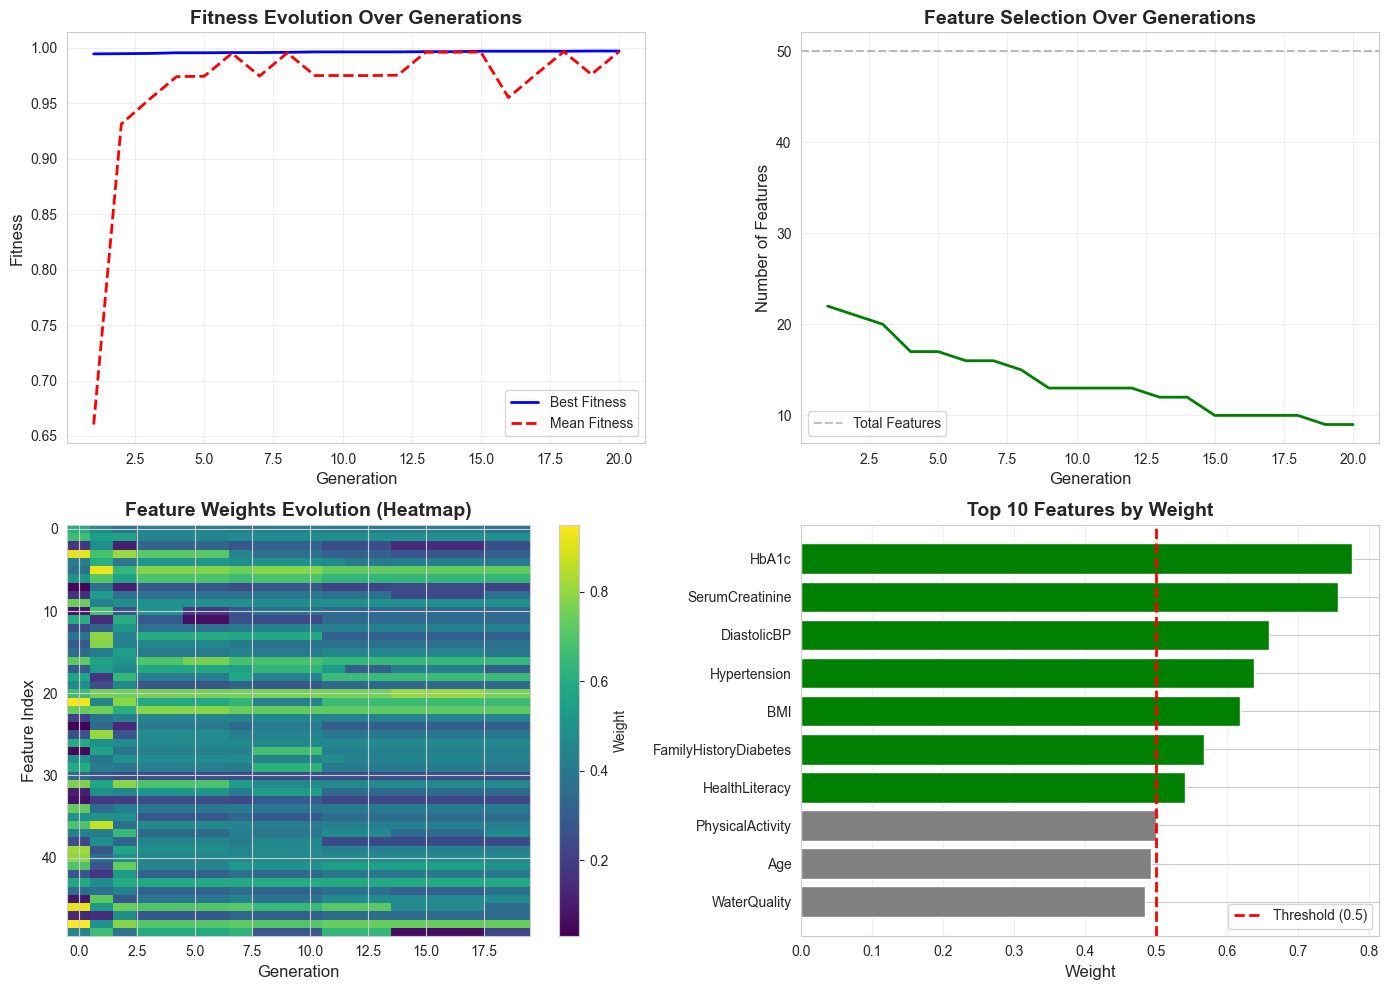

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

generations = range(1, len(history['best_fitness']) + 1)

# Plot 1: Fitness Evolution
ax1 = axes[0, 0]
ax1.plot(generations, history['best_fitness'], 'b-', linewidth=2, label='Best Fitness')
ax1.plot(generations, history['mean_fitness'], 'r--', linewidth=2, label='Mean Fitness')
ax1.set_xlabel('Generation', fontsize=12)
ax1.set_ylabel('Fitness', fontsize=12)
ax1.set_title('Fitness Evolution Over Generations', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Number of Selected Features
ax2 = axes[0, 1]
ax2.plot(generations, history['n_selected_features'], 'g-', linewidth=2)
ax2.axhline(y=len(feature_names), color='gray', linestyle='--', alpha=0.5, label='Total Features')
ax2.set_xlabel('Generation', fontsize=12)
ax2.set_ylabel('Number of Features', fontsize=12)
ax2.set_title('Feature Selection Over Generations', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Feature Weights Heatmap
ax3 = axes[1, 0]
weights_over_time = np.array(history['best_weights'])
im = ax3.imshow(weights_over_time.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax3.set_xlabel('Generation', fontsize=12)
ax3.set_ylabel('Feature Index', fontsize=12)
ax3.set_title('Feature Weights Evolution (Heatmap)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax3, label='Weight')

# Plot 4: Final Feature Weights Bar Chart
ax4 = axes[1, 1]
sorted_indices = np.argsort(best_weights)[::-1][:10]  # Top 10 features
top_features = [feature_names[i] for i in sorted_indices]
top_weights = [best_weights[i] for i in sorted_indices]
colors = ['green' if w >= ga.weight_threshold else 'gray' for w in top_weights]
ax4.barh(range(len(top_features)), top_weights, color=colors)
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features, fontsize=10)
ax4.set_xlabel('Weight', fontsize=12)
ax4.set_title('Top 10 Features by Weight', fontsize=14, fontweight='bold')
ax4.axvline(x=ga.weight_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({ga.weight_threshold})')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Compare Different Operator Combinations

Run multiple GA experiments with different selection and crossover operator combinations.

Comparing Selection and Crossover Operator Combinations...

Testing tournament selection + arithmetic crossover...
  ✅ tournament + arithmetic: Fitness = 0.9965, Features = 12
     Improvement: 0.0020


Operator Combination Comparison:


,Selection,Crossover,Best Fitness,Final Features,Initial Fitness,Final Fitness,Improvement
0,tournament,arithmetic,0.996536,12,0.994536,0.996536,0.002


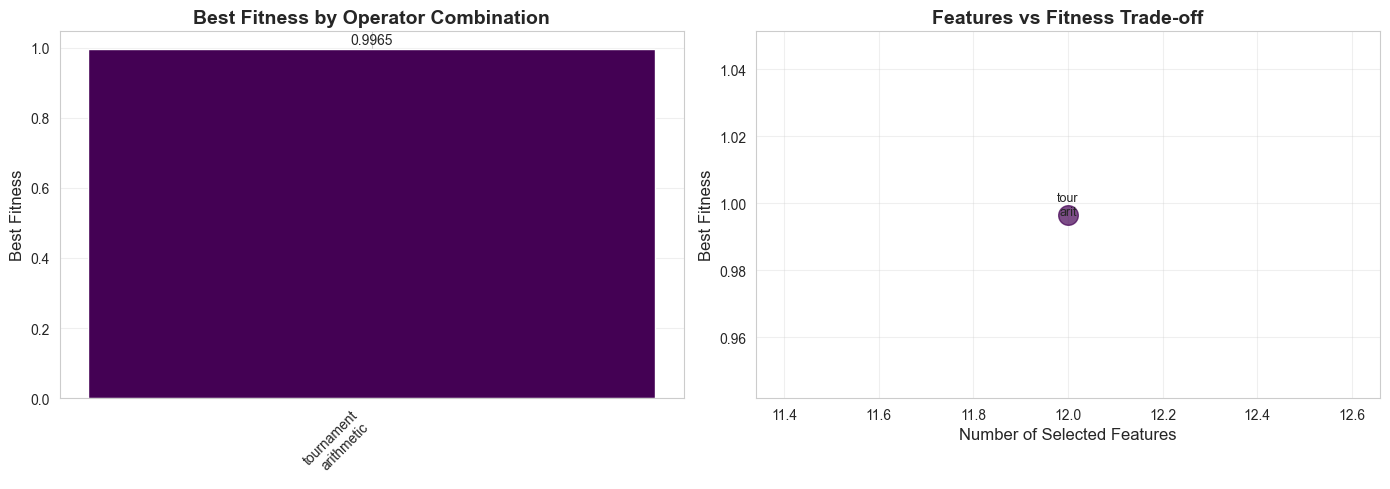


📊 Analysis:
Best configuration: tournament selection + arithmetic crossover
Best fitness: 0.9965
Features selected: 12
CPU times: total: 4.16 s
Wall time: 17.7 s


In [17]:
%%time

# Compare different operator combinations
print("Comparing Selection and Crossover Operator Combinations...\n")

# Define operator sets
selection_methods = ['tournament']  # Add 'roulette', 'rank' when implemented
crossover_methods = ['arithmetic']  # Add 'single_point', 'uniform' when implemented

# Note: For now, only 'tournament' selection and 'arithmetic' crossover are fully implemented
# Other operators have placeholders that fall back to implemented versions

comparison_results = []

for selection in selection_methods:
    for crossover in crossover_methods:
        print(f"Testing {selection} selection + {crossover} crossover...")
        
        ga_test = GeneticAlgorithm(
            dataset_path=dataset_path,
            population_size=25,
            n_generations=15,
            selection_method=selection,
            crossover_method=crossover,
            mutation_method='uniform',
            elitism_rate=0.1,
            random_state=42
        )
        
        # Turn off verbose output for comparison
        original_verbose = config.VERBOSE
        config.VERBOSE = False
        
        weights, fitness, hist, features = ga_test.evolve()
        
        config.VERBOSE = original_verbose
        
        comparison_results.append({
            'Selection': selection,
            'Crossover': crossover,
            'Best Fitness': fitness,
            'Final Features': len(features),
            'Initial Fitness': hist['best_fitness'][0],
            'Final Fitness': hist['best_fitness'][-1],
            'Improvement': hist['best_fitness'][-1] - hist['best_fitness'][0]
        })
        
        print(f"  ✅ {selection} + {crossover}: Fitness = {fitness:.4f}, Features = {len(features)}")
        print(f"     Improvement: {hist['best_fitness'][-1] - hist['best_fitness'][0]:.4f}\n")

# Display comparison
comparison_df = pd.DataFrame(comparison_results)
print("\nOperator Combination Comparison:")
print("="*80)
display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Best Fitness by Configuration
ax1 = axes[0]
labels = [f"{row['Selection']}\n{row['Crossover']}" for _, row in comparison_df.iterrows()]
colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))
bars = ax1.bar(range(len(comparison_df)), comparison_df['Best Fitness'], color=colors)
ax1.set_xticks(range(len(comparison_df)))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylabel('Best Fitness', fontsize=12)
ax1.set_title('Best Fitness by Operator Combination', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, comparison_df['Best Fitness'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Features vs Fitness scatter
ax2 = axes[1]
scatter = ax2.scatter(comparison_df['Final Features'], comparison_df['Best Fitness'], 
                     s=200, c=range(len(comparison_df)), cmap='viridis', alpha=0.7)
for i, row in comparison_df.iterrows():
    ax2.annotate(f"{row['Selection'][:4]}\n{row['Crossover'][:4]}", 
                (row['Final Features'], row['Best Fitness']),
                fontsize=9, ha='center')
ax2.set_xlabel('Number of Selected Features', fontsize=12)
ax2.set_ylabel('Best Fitness', fontsize=12)
ax2.set_title('Features vs Fitness Trade-off', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Analysis:")
best_config = comparison_df.loc[comparison_df['Best Fitness'].idxmax()]
print(f"Best configuration: {best_config['Selection']} selection + {best_config['Crossover']} crossover")
print(f"Best fitness: {best_config['Best Fitness']:.4f}")
print(f"Features selected: {best_config['Final Features']}")

## 8. Analyze Elitism Impact

Compare different elitism rates to see their effect on convergence.

Testing Elitism Rates...

Testing elitism_rate = 0.05...
  ✅ Final fitness: 0.9971

Testing elitism_rate = 0.10...
  ✅ Final fitness: 0.9957

Testing elitism_rate = 0.20...
  ✅ Final fitness: 0.9963

Testing elitism_rate = 0.30...
  ✅ Final fitness: 0.9963



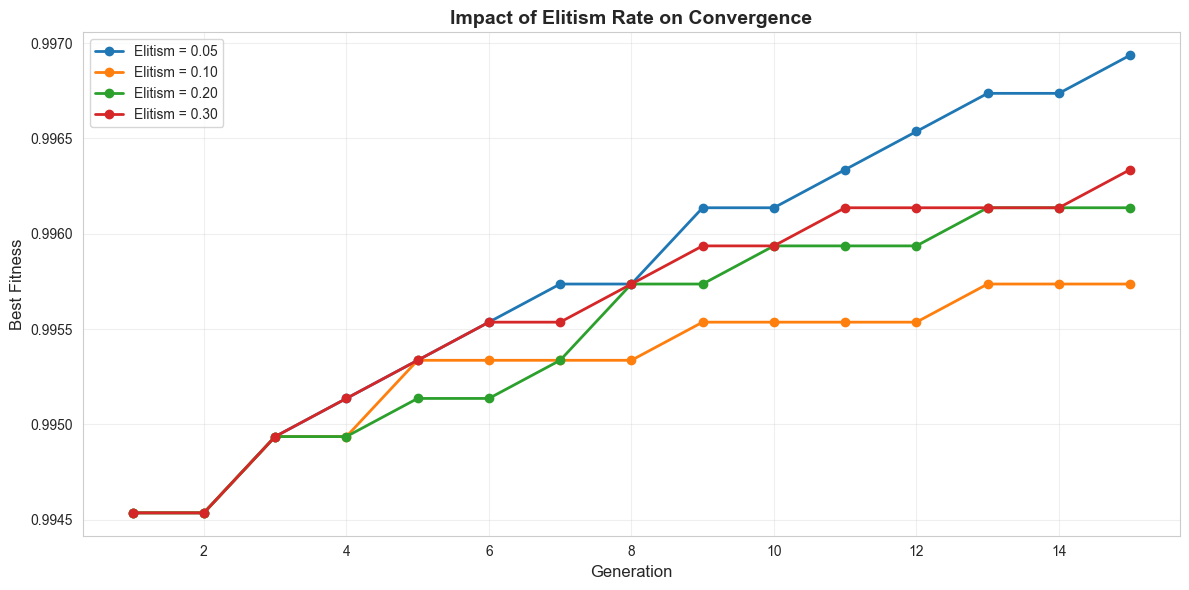


Observation:
- Higher elitism rates preserve more top solutions
- Lower elitism allows more exploration (diversity)
- Optimal rate depends on problem and population size
CPU times: total: 10.2 s
Wall time: 56.5 s


In [18]:
%%time

# Test different elitism rates
elitism_rates = [0.05, 0.1, 0.2, 0.3]
elitism_results = {}

print("Testing Elitism Rates...\n")

config.VERBOSE = False

for elitism in elitism_rates:
    print(f"Testing elitism_rate = {elitism:.2f}...")
    
    ga_elitism = GeneticAlgorithm(
        dataset_path=dataset_path,
        population_size=20,
        n_generations=15,
        elitism_rate=elitism,
        random_state=42
    )
    
    _, fitness, hist, _ = ga_elitism.evolve()
    elitism_results[elitism] = hist['best_fitness']
    
    print(f"  ✅ Final fitness: {fitness:.4f}\n")

config.VERBOSE = True

# Plot comparison
plt.figure(figsize=(12, 6))
for elitism, fitness_history in elitism_results.items():
    plt.plot(range(1, len(fitness_history) + 1), fitness_history, 
             linewidth=2, marker='o', label=f'Elitism = {elitism:.2f}')

plt.xlabel('Generation', fontsize=12)
plt.ylabel('Best Fitness', fontsize=12)
plt.title('Impact of Elitism Rate on Convergence', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation:")
print("- Higher elitism rates preserve more top solutions")
print("- Lower elitism allows more exploration (diversity)")
print("- Optimal rate depends on problem and population size")

## Summary

This notebook demonstrated:

1. ✅ **Loading data** from the processed diabetes dataset
2. ✅ **Initializing the GA** with custom parameters
3. ✅ **Running evolution** with elitism, selection, crossover, and mutation
4. ✅ **Analyzing results** - best fitness, selected features, convergence
5. ✅ **Visualizing** fitness evolution, feature selection, and weight distributions
6. ✅ **Comparing operators** to find the best configuration
7. ✅ **Analyzing elitism** impact on convergence behavior

### Key Insights

- **Continuous weights** allow smooth optimization (not binary)
- **Elitism** preserves good solutions and speeds convergence
- **Feature reduction** is achieved through the fitness penalty term
- **Threshold (0.5)** converts weights to binary feature selection

### Next Steps

1. Implement remaining operators (roulette, rank selection, etc.)
2. Run longer experiments with larger populations
3. Compare results against baseline (all features)
4. Analyze feature importance and interpretability